# Implementing Alternating Least Squares using NumPy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
plt.style.use('ggplot')

%matplotlib inline

In [3]:
class ALSRecommender:
    def __init__(self, n_factors: int = 10, n_iterations: int = 20, reg_param: float = 0.1):
        """
        Initializes the ALSRecommender.
        
        Parameters:
        - n_factors (int): Number of latent features.
        - n_iterations (int): Number of iterations to perform.
        - reg_param (float): Regularization parameter for ALS.
        """
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.reg_param = reg_param
        self.rating_matrix = None
        self.user_factors = None
        self.item_factors = None
        self.n_users = None
        self.n_items = None

    def fit(self, ratings: np.ndarray) -> None:
        """
        Trains the ALS model using the given user-item rating matrix.
        
        Parameters:
        - ratings (np.ndarray): User-item rating matrix with shape (n_users, n_items).
        """ 
        self.rating_matrix = ratings
        self.n_users, self.n_items = ratings.shape
        self.user_factors = np.random.rand(self.n_users, self.n_factors)
        self.item_factors = np.random.rand(self.n_items, self.n_factors)
        
        for _ in range(self.n_iterations):
            self.update_users()
            self.update_items()
    
    def update_items(self) -> np.ndarray:
        """
        Updates items factors matrix.
           
        Returns:
        - np.ndarray: Updated user factors matrix.
        """
        for i in range(len(self.item_factors)):
            rateds = self.rating_matrix[:, i] != 0
            rated_indices = np.where(rateds)[0]
            rated_vectors = self.user_factors[rateds]

            reshaped_vectors = rated_vectors.reshape(-1, self.n_factors, 1)
            ratings_i = self.rating_matrix[rated_indices, i].reshape(-1, 1, 1)

            A = np.sum(reshaped_vectors @ reshaped_vectors.transpose(0, 2, 1), axis=0)
            b = np.sum(reshaped_vectors * ratings_i, axis=0)

            A += np.eye(self.n_factors) * self.reg_param
            A_inv = np.linalg.inv(A)

            self.item_factors[i] = (A_inv @ b).flatten()

        return self.item_factors
    
    def update_users(self) -> np.ndarray:
        """
        Updates user factors matrix.
        
        Returns:
        - np.ndarray: Updated user factors matrix.
        """
        for i in range(len(self.user_factors)):
            rateds = self.rating_matrix[i] != 0
            rated_indices = np.where(rateds)[0]
            rated_vectors = self.item_factors[rateds]

            reshaped_vectors = rated_vectors.reshape(-1, self.n_factors, 1)
            
            ratings_i = self.rating_matrix[i, rated_indices].reshape(-1, 1, 1)

            A = np.sum(reshaped_vectors @ reshaped_vectors.transpose(0, 2, 1), axis=0)
            b = np.sum(reshaped_vectors * ratings_i, axis=0)

            A += np.eye(self.n_factors) * self.reg_param
            A_inv = np.linalg.inv(A)

            self.user_factors[i] = (A_inv @ b).flatten()

        return self.user_factors

    def predict(self) -> np.ndarray:
        """
        Generates the predicted rating matrix.
        
        Returns:
        - np.ndarray: Predicted user-item rating matrix.
        """
        return self.user_factors @ self.item_factors.T
        
    def evaluate(self, test_ratings: np.ndarray) -> float:
        """
        Evaluates the model on test data using RMSE.
        
        Parameters:
        - test_ratings (np.ndarray): User-item rating matrix for testing.
        
        Returns:
        - float: Root Mean Square Error (RMSE).
        """
        predictions = self.predict()
        errors = predictions - test_ratings
        return np.sqrt(np.mean(errors**2))


# Apply the model to book ratings dataset

## 1. Load Data

In [4]:
books_filename = 'books.csv'
ratings_filename = 'ratings.csv'

df_books = pd.read_csv(
    books_filename, 
    encoding = "ISO-8859-1", 
    usecols=['isbn', 'title'], 
    dtype={'isbn': 'string', 'title': 'str'})

df_ratings = pd.read_csv(
    ratings_filename, 
    encoding = "ISO-8859-1", 
    usecols=['userId', 'isbn', 'rating'],
    dtype={'userId': 'int32', 'isbn': 'string', 'rating': 'int32'})

In [5]:
# Filter out ratings for books not in the books dataset
df_ratings = df_ratings[df_ratings.isbn.isin(df_books.isbn)]

In [6]:
df_books.head()

,isbn,title
0,0195153448,Classical Mythology
1,0002005018,Clara Callan
2,0060973129,Decision in Normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic...
4,0393045218,The Mummies of Urumchi


In [7]:
df_ratings.head()

,userId,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
num_books = len(df_ratings.isbn.unique())
num_users = len(df_ratings.userId.unique())
print('There are {} unique books and {} unique users'.format(num_books, num_users))

There are 270170 unique books and 92107 unique users


## 2. Exploratory Data Analysis

### 2.1 Plot the count of each rating

In [9]:
df_ratings_cnt = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt

,count
rating,
0,647323
1,1481
2,2375
3,5118
4,7617
5,45355
6,31689
7,66404
8,91806


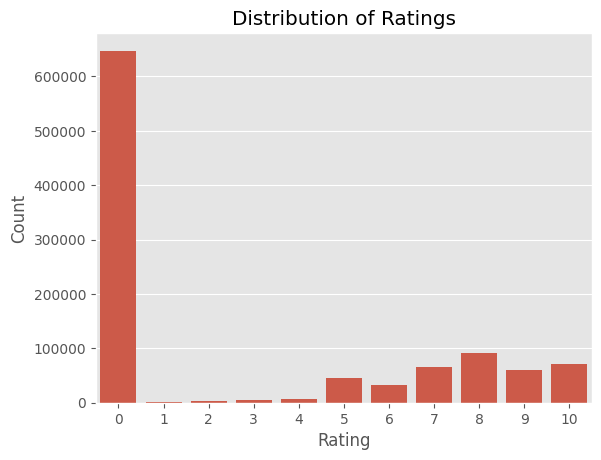

In [10]:
sns.countplot(x='rating', data=df_ratings)

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

Wow, there are a lot of 0 ratings here. This could be because unrated books are marked as 0. Will this affect the model? XD

### 2.2 Plot rating frequency of all books

In [11]:
df_books_freq = pd.DataFrame(df_ratings.groupby('isbn').size(), columns=['count'])
df_books_freq

,count
isbn,
0000913154,1
0001010565,2
0001046438,1
0001046713,1
000104687X,1
...,...
B000234N76,1
B000234NC6,1
B00029DGGO,1


Text(0, 0.5, 'number of ratings')

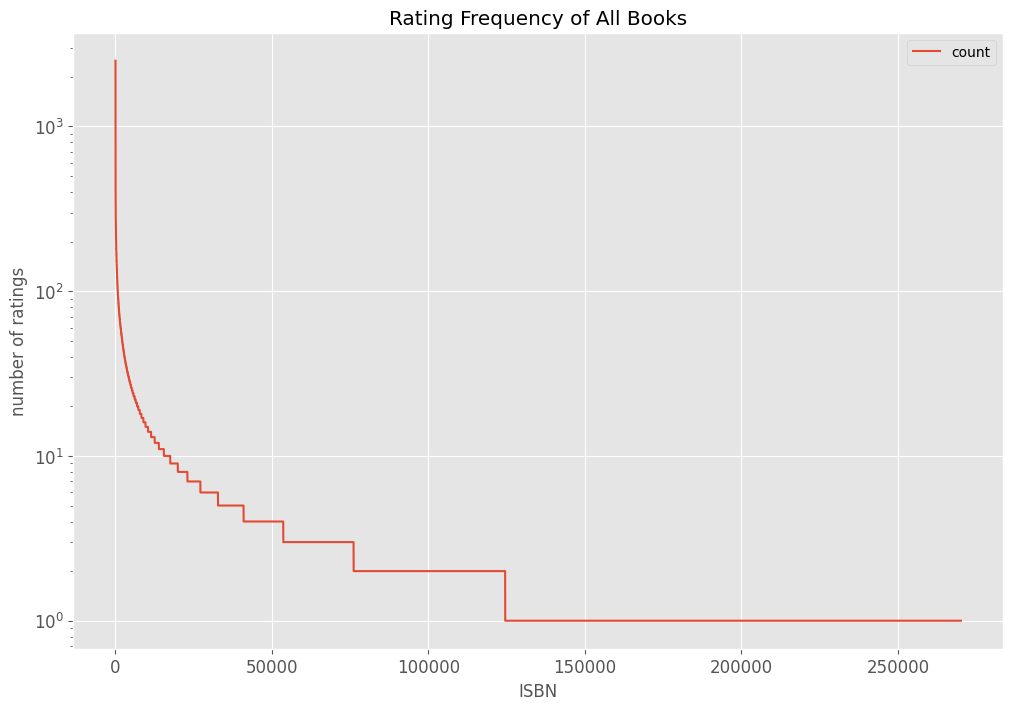

In [12]:
ax = df_books_freq \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Books',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("ISBN")
ax.set_ylabel("number of ratings")

Here, we encounter the Long Tail property. "A long tail of some distributions of numbers is the portion of the distribution having many occurrences far from the "head" or central part of the distribution" (Wiki). Only small fraction of books are rated frequently. Such books are refered as popular books. The vast majority of books are rated rarely. This results in a highly skewed distribution of the underlying ratings.

In [13]:
df_books_freq['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    2502.0
0.95      12.0
0.90       7.0
0.85       5.0
0.80       3.0
0.75       3.0
0.70       2.0
0.65       2.0
Name: count, dtype: float64

Approximately 1% of books have around 2502 or more ratings. Additionally, 5% of books have 10 or more ratings, and 10% have 6 or more ratings. Given the large number of books, we will limit our analysis to the top 5%, which corresponds to 17,500 books.

In [14]:
popularity_thres = 10
popular_books = list(set(df_books_freq.query('count >= @popularity_thres').index))
df_ratings_drop = df_ratings[df_ratings.isbn.isin(popular_books)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular books: ', df_ratings_drop.shape)

shape of original ratings data:  (1031175, 3)
shape of ratings data after dropping unpopular books:  (520499, 3)


Demn, I just dropped like 50% of the ratings from the dataset. But no worries, I am sure we still have a lot of books to play with.

In [15]:
df_users_freq = pd.DataFrame(df_ratings.groupby('userId').size(), columns=['count'])
df_users_freq

,count
userId,
2,1
8,17
9,3
10,1
12,1
...,...
278846,1
278849,4
278851,23


Text(0, 0.5, 'number of ratings')

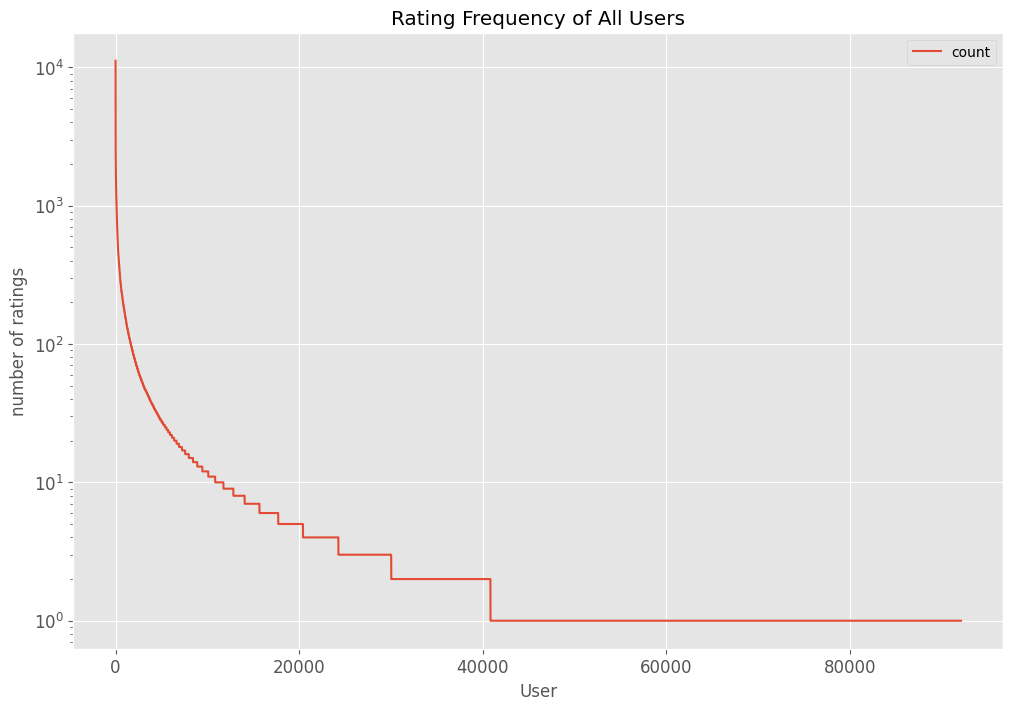

In [16]:
ax = df_users_freq \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("User")
ax.set_ylabel("number of ratings")

In [17]:
df_users_freq['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    11144.0
0.95       31.0
0.90       13.0
0.85        8.0
0.80        5.0
0.75        4.0
0.70        3.0
0.65        2.0
Name: count, dtype: float64

Voilà, we are seeing the same distribution again! Only a very small fraction of users are very actively engaged with rating books that they watched. Vast majority of users aren't interested in rating books. So we can limit users to the top ~10% (users that rated more than 10 times), which is about 10,528 users. 

In [18]:
ratings_thres = 10
active_users = list(set(df_users_freq.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop[df_ratings_drop.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular books and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (1031175, 3)
shape of ratings data after dropping both unpopular books and inactive users:  (428085, 3)


## 3. Train the ALS model

In [19]:
# pivot and create movie-user matrix
ratings_matrix = df_ratings_drop_users.pivot(index='userId', columns='isbn', values='rating').fillna(0)
# create mapper from movie title to index
idx_to_book = {
    i: movie for i, movie in 
    enumerate(list(df_books.set_index('isbn').loc[ratings_matrix.columns].title))
}
# Convert the DataFrame to a NumPy array
ratings_matrix_numpy = ratings_matrix.to_numpy()
ratings_matrix_numpy

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
ratings_matrix_numpy.shape

(11598, 17478)

In [21]:
# Initialize the ALSRecommender
als_recommender = ALSRecommender(n_factors=10, n_iterations=20, reg_param=0.1)

# Fit the model
als_recommender.fit(ratings_matrix_numpy)

# Compute the predicted ratings
predicted_ratings = als_recommender.predict()

In [24]:
def recommend_items(user_id, num_recommendations=5):
    user_idx = ratings_matrix.index.get_loc(user_id)
    user_ratings = predicted_ratings[user_idx]
    top_items = np.argsort(user_ratings)[::-1][:num_recommendations]
    recommended_books = [(idx_to_book[i], user_ratings[i]) for i in top_items]
    return recommended_books

In [28]:
user_id = 276847
recommendations = recommend_items(user_id)
print(f"Recommendations for user {user_id}:")
for i, book in enumerate(recommendations):
    print(f"{i + 1}: {book}")

Recommendations for user 276847:
1: ('Seinlanguage', 16.86705636427059)
2: ('The Shell Seekers (Shell Seekers)', 16.308068516816423)
3: ('Triggerfish Twist', 15.974471783380434)
4: ('Middlemarch (Wadsworth Series in Mass Communication)', 15.661937757829968)
5: ('Imitation in Death (Eve Dallas Mysteries (Paperback))', 15.262028836795311)
